In [1]:
%matplotlib inline

import ast
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
import matplotlib.gridspec as gridspec

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from itertools import groupby
from scipy import integrate
from tqdm import tqdm
from matplotlib.lines import Line2D


plt.style.use('ggplot')
pd.set_option('chained_assignment',None)

sys.path.append(os.path.join( '..'))
from miriam_py.utils import load_config
data_path = load_config()['paths']['data']

In [2]:
def sum_tuples(l):
    return tuple(sum(x) for x in zip(*l))

def calc_risk_total(x,hazard,RPS,events):
    collect_risks = []
    for y in range(7):
        collect_risks.append(integrate.simps([x[y] for x in x[events]][::-1], x=RPS[::-1]))
    return collect_risks

def set_prot_standard(x,prot_lookup,events):
    prot_stand = prot_lookup[x.region]
    no_floods= [z for z in events if prot_stand > int(z.split('-')[1])]
    for no_flood in no_floods:
        x[no_flood] = (0,0,0,0,0,0,0)
    return x

def pluvial_design(x,hazard):
    if x.GroupCode == 'HIC':
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
            elif hazard == 'CF':
                x[['CF-10','CF-20','CF-50']] = [(0,0,0,0,0,0,0)]*3               
        else:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'CF':
                x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2
    elif x.GroupCode == 'UMC':
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10','PU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'FU':
                x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3
            elif hazard == 'CF':
                x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2
        else:
            if hazard == 'PU':
                x[['PU-5','PU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'FU':
                x[['FU-5','FU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'CF':
                x[['CF-10']] = [(0,0,0,0,0,0,0)]*1
    else:
        if x.road_type in ['primary','secondary']:
            if hazard == 'PU':
                x[['PU-5','PU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'FU':
                x[['FU-5','FU-10']] = [(0,0,0,0,0,0,0)]*2
            elif hazard == 'CF':
                x[['CF-10']] = [(0,0,0,0,0,0,0)]*1
       
    return x

def pluvial_design_rail(x,hazard):
    if (hazard == 'PU'):
        if  x.GroupCode == 'HIC':
            x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
        elif x.GroupCode == 'UMC':
            x[['PU-5','PU-10','PU-20','PU-50']] = [(0,0,0,0,0,0,0)]*4
        else:
            x[['PU-5','PU-10','PU-20']] =[(0,0,0,0,0,0,0)]*3

    if (hazard == 'FU'):
        if  x.GroupCode == 'HIC':
            x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
        elif x.GroupCode == 'UMC':
            x[['FU-5','FU-10','FU-20','FU-50']] = [(0,0,0,0,0,0,0)]*4
        else:
            x[['FU-5','FU-10','FU-20']] = [(0,0,0,0,0,0,0)]*3


    if (hazard == 'CF'):
        if  x.GroupCode == 'HIC':
            x[['CF-10','CF-20','CF-50',]] =[(0,0,0,0,0,0,0)]*3
        elif x.GroupCode == 'UMC':
            x[['CF-10','CF-20','CF-50']] = [(0,0,0,0,0,0,0)]*3
        else:
            x[['CF-10','CF-20']] = [(0,0,0,0,0,0,0)]*2

    return x

def get_value(x,ne_sindex,ne_countries,col):
    matches = ne_countries.loc[ne_sindex.intersection(x.centroid.bounds[:2])]
    
    for match in matches.iterrows():
        if match[1].geometry.intersects(x) == True:
            return match[1][col]

In [3]:
%%time
global_countries = gpd.read_file(os.path.join(data_path,'input_data','global_countries.shp'))
global_regions = gpd.read_file(os.path.join(data_path,'input_data','global_regions_v2.shp'))
prot_lookup = dict(zip(global_regions['GID_2'],global_regions['prot_stand']))
ne_countries = gpd.read_file(os.path.join(data_path,'input_data','ne_50m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex

incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])
global_countries['GDP'] = global_countries.geometry.apply(lambda x: get_value(x,ne_sindex,ne_countries,'GDP_MD_EST'))
GDP_group = global_countries.merge(incomegroups,left_on='ISO_3digit',right_on='CountryCode').groupby('GroupName')['GDP'].sum()
GDP_group = pd.DataFrame(GDP_group)
GDP_group = GDP_group*1000

Wall time: 5.39 s


In [4]:
wbccodes = pd.read_csv(os.path.join(data_path,'input_data','wbccodes2014.csv'),index_col=[0])
wbc_lookup = dict(zip(wbccodes.index,wbccodes.wbregion))
def wbregion(x):
    try:
        return wbc_lookup[x]
    except:
        return 'YHI'

In [5]:
rail_to_remove =['disused','abandoned','dismantled','preserved', 'proposed','razed', 
                 'planned','no','historical','na','not_built','abandonned', 'uncompleted', 'demolished',
                 'abandoned_tram','construction;rail', 'rail;construction','waste_disposal','collapsed']

In [6]:
%%time
events_FU = ['FU-5', 'FU-10', 'FU-20', 'FU-50', 'FU-75', 'FU-100', 'FU-200', 'FU-250','FU-500', 'FU-1000']
tot_road_FU = pd.read_csv(os.path.join(data_path,'summarized','FU_road_losses.csv'),
                          converters = dict(zip(events_FU,[ast.literal_eval]*len(events_FU))),index_col=[0]) 
print('FU loaded')

events_PU = ['PU-5', 'PU-10', 'PU-20', 'PU-50', 'PU-75', 'PU-100', 'PU-200', 'PU-250', 'PU-500', 'PU-1000']
tot_road_PU = pd.read_csv(os.path.join(data_path,'summarized','PU_road_losses.csv'),
                          converters = dict(zip(events_PU,[ast.literal_eval]*len(events_PU))),index_col=[0]) 
print('PU loaded')

events_EQ = ['EQ_rp250','EQ_rp475','EQ_rp975','EQ_rp1500','EQ_rp2475'] 
tot_road_EQ = pd.read_csv(os.path.join(data_path,'summarized','EQ_road_losses.csv'),
                          converters = dict(zip(events_EQ,[ast.literal_eval]*len(events_EQ))),index_col=[0]) 
print('EQ loaded')

events_Cyc = ['Cyc_rp50','Cyc_rp100','Cyc_rp250','Cyc_rp500','Cyc_rp1000']
tot_road_Cyc = pd.read_csv(os.path.join(data_path,'summarized','Cyc_road_losses_uncer.csv'),
                           converters = dict(zip(events_Cyc,[ast.literal_eval]*len(events_Cyc))))
print('Cyc loaded')

events_CF = ['CF-10', 'CF-20', 'CF-50', 'CF-100', 'CF-200', 'CF-500', 'CF-1000']
tot_road_CF = pd.read_csv(os.path.join(data_path,'summarized','CF_road_losses.csv'),
                          converters = dict(zip(events_CF,[ast.literal_eval]*len(events_CF))),index_col=[0])

FU loaded
PU loaded
EQ loaded
Cyc loaded
Wall time: 1min 3s


In [7]:
%%time
events_FU = ['FU-5', 'FU-10', 'FU-20', 'FU-50', 'FU-75', 'FU-100', 'FU-200', 'FU-250','FU-500', 'FU-1000']
tot_rail_FU = pd.read_csv(os.path.join(data_path,'summarized','FU_rail_losses.csv'),
                          converters = dict(zip(events_FU,[ast.literal_eval]*len(events_FU))),index_col=[0]) 
print('FU loaded')

events_PU = ['PU-5', 'PU-10', 'PU-20', 'PU-50', 'PU-75', 'PU-100', 'PU-200', 'PU-250', 'PU-500', 'PU-1000']
tot_rail_PU = pd.read_csv(os.path.join(data_path,'summarized','PU_rail_losses.csv'),
                          converters = dict(zip(events_PU,[ast.literal_eval]*len(events_PU))),index_col=[0]) 
print('PU loaded')

events_EQ = ['EQ_rp250','EQ_rp475','EQ_rp975','EQ_rp1500','EQ_rp2475'] 
tot_rail_EQ = pd.read_csv(os.path.join(data_path,'summarized','EQ_rail_losses.csv'),
                          converters = dict(zip(events_EQ,[ast.literal_eval]*len(events_EQ))),index_col=[0]) 
print('EQ loaded')

events_Cyc = ['Cyc_rp50','Cyc_rp100','Cyc_rp250','Cyc_rp500','Cyc_rp1000']
tot_rail_Cyc = pd.read_csv(os.path.join(data_path,'summarized','Cyc_rail_losses.csv'),
                           converters = dict(zip(events_Cyc,[ast.literal_eval]*len(events_Cyc))))
print('Cyc loaded')

events_CF = ['CF-10', 'CF-20', 'CF-50', 'CF-100', 'CF-200', 'CF-500', 'CF-1000']
tot_rail_CF = pd.read_csv(os.path.join(data_path,'summarized','CF_rail_losses.csv'),
                          converters = dict(zip(events_CF,[ast.literal_eval]*len(events_CF))),index_col=[0])

print('CF loaded')

FU loaded
PU loaded
EQ loaded
Cyc loaded
CF loaded
Wall time: 12.9 s


In [8]:
%%time
tot_bridge_road = pd.read_csv(os.path.join(data_path,'summarized','bridge_road_risk_.csv'),index_col=[0],
                              converters = dict(zip(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'],[ast.literal_eval]*5)))

tot_bridge_road.IncomeGroup = tot_bridge_road.IncomeGroup.apply(lambda x :x.upper())
#tot_bridge_road.IncomeGroup = tot_bridge_road.country.apply(lambda x :wbregion(x))

tot_bridge_rail = pd.read_csv(os.path.join(data_path,'summarized','bridge_rail_risk_.csv'),
                          converters = dict(zip(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'],[ast.literal_eval]*len(['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk']))),index_col=[0])

tot_bridge_rail.IncomeGroup = tot_bridge_rail.IncomeGroup.apply(lambda x :x.upper())
#tot_bridge_rail.IncomeGroup = tot_bridge_rail.country.apply(lambda x :wbregion(x))

wb_road_bridge = tot_bridge_road.loc[tot_bridge_road.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['IncomeGroup'])['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'].agg(sum_tuples)

wb_rail_bridge = tot_bridge_rail.groupby(['IncomeGroup'])['CF_risk','Cyc_risk','EQ_risk','FU_risk','PU_risk'].agg(sum_tuples)
                          

Wall time: 11.6 s


In [9]:
tot_road_FU = tot_road_FU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_road_PU = tot_road_PU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_road_Cyc = tot_road_Cyc.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_road_EQ = tot_road_EQ.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_road_CF = tot_road_CF.merge(incomegroups,left_on='country',right_on='CountryCode')

tot_rail_FU = tot_rail_FU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_rail_PU = tot_rail_PU.merge(incomegroups,left_on='country',right_on='CountryCode').merge(global_countries[['ISO_3digit','wbregion']],left_on='country',right_on='ISO_3digit')
tot_rail_Cyc = tot_rail_Cyc.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_rail_EQ = tot_rail_EQ.merge(incomegroups,left_on='country',right_on='CountryCode')
tot_rail_CF = tot_rail_CF.merge(incomegroups,left_on='country',right_on='CountryCode')

In [10]:
%%time
tqdm.pandas()
tot_road_FU = tot_road_FU.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_FU),axis=1)
tot_road_CF = tot_road_CF.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_CF),axis=1)

tot_rail_FU = tot_rail_FU.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_FU),axis=1)
tot_rail_CF = tot_rail_CF.progress_apply(lambda x : set_prot_standard(x,prot_lookup,events_CF),axis=1)

tot_road_FU = tot_road_FU.progress_apply(lambda x : pluvial_design(x,'FU'),axis=1)
tot_road_CF = tot_road_CF.progress_apply(lambda x : pluvial_design(x,'CF'),axis=1)
tot_road_PU = tot_road_PU.progress_apply(lambda x : pluvial_design(x,'PU'),axis=1)

tot_rail_FU = tot_rail_FU.progress_apply(lambda x : pluvial_design_rail(x,'FU'),axis=1)
tot_rail_CF = tot_rail_CF.progress_apply(lambda x : pluvial_design_rail(x,'CF'),axis=1)
tot_rail_PU = tot_rail_PU.progress_apply(lambda x : pluvial_design_rail(x,'PU'),axis=1)

100%|██████████████████████████████████████████████████████████████████████████| 40907/40907 [00:18<00:00, 2180.62it/s]


Wall time: 3min 13s


In [11]:
FU_wb_stats_road = tot_road_FU.loc[tot_road_FU.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['road_type','GroupName'])[events_FU].agg(sum_tuples)
PU_wb_stats_road = tot_road_PU.loc[tot_road_PU.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['road_type','GroupName'])[events_PU].agg(sum_tuples)
Cyc_wb_stats_road = tot_road_Cyc.loc[tot_road_Cyc.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['road_type','GroupName'])[events_Cyc].agg(sum_tuples)
EQ_wb_stats_road = tot_road_EQ.loc[tot_road_EQ.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['road_type','GroupName'])[events_EQ].agg(sum_tuples)
CF_wb_stats_road = tot_road_CF.loc[tot_road_CF.road_type.isin(['primary','secondary','tertiary'])].groupby(
    ['road_type','GroupName'])[events_CF].agg(sum_tuples)

In [12]:
FU_wb_stats_rail = tot_rail_FU.loc[~(tot_rail_FU.infra_type.isin(rail_to_remove))].groupby(
    ['GroupName'])[events_FU].agg(sum_tuples)
PU_wb_stats_rail = tot_rail_PU.loc[~(tot_rail_PU.infra_type.isin(rail_to_remove))].groupby(
                ['GroupName'])[events_PU].agg(sum_tuples)
Cyc_wb_stats_rail = tot_rail_Cyc.loc[~(tot_rail_Cyc.infra_type.isin(rail_to_remove))].groupby(
    ['GroupName'])[events_Cyc].agg(sum_tuples)
EQ_wb_stats_rail = tot_rail_EQ.loc[~(tot_rail_EQ.infra_type.isin(rail_to_remove))].groupby(
    ['GroupName'])[events_EQ].agg(sum_tuples)
CF_wb_stats_rail = tot_rail_CF.loc[~(tot_rail_CF.infra_type.isin(rail_to_remove))].groupby(
    ['GroupName'])[events_CF].agg(sum_tuples)

In [13]:
tot_roads = pd.read_feather(os.path.join(data_path,'summarized','all_road_stats.ft'))
tot_roads = tot_roads.loc[tot_roads.road_type.isin(['primary','secondary','tertiary'])]
tot_roads = tot_roads.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_roads = tot_roads.merge(incomegroups,left_on='country',right_on='CountryCode')
#tot_roads['GroupName'] = tot_roads.country.apply(lambda x : wbregion(x)) 
tot_len_road = pd.DataFrame(tot_roads.groupby('GroupName')['length'].sum(),columns=['length'])
lookup_length_road = dict(zip(tot_roads.index,tot_roads.length))

In [14]:
tot_rail = pd.read_feather(os.path.join(data_path,'summarized','all_railway_stats.ft'))
tot_rail = tot_rail.loc[~(tot_rail.infra_type.isin(rail_to_remove))]

tot_rail = tot_rail.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_rail = tot_rail.merge(incomegroups,left_on='country',right_on='CountryCode')
#tot_rail['GroupName'] = tot_rail.country.apply(lambda x : wbregion(x)) 

tot_len_rail = pd.DataFrame(tot_rail.groupby('GroupName')['length'].sum(),columns=['length'])

tot_len = tot_len_road.add(tot_len_rail, fill_value=0)
lookup_length = dict(zip(tot_len.index,tot_len.length))

In [15]:
total_infra_value = pd.read_csv(os.path.join(data_path,'summarized','total_infrastructure_values.csv'))
total_infra_value = total_infra_value.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
total_infra_value = total_infra_value.merge(incomegroups,left_on='country',right_on='CountryCode')
wbinc_infra_value = pd.DataFrame(total_infra_value.groupby('GroupName')['infra_value'].sum(),columns=['infra_value'])
#lookup_length = dict(zip(wbinc_infra_value.index,wbinc_infra_value.infra_value))

## Figure 4

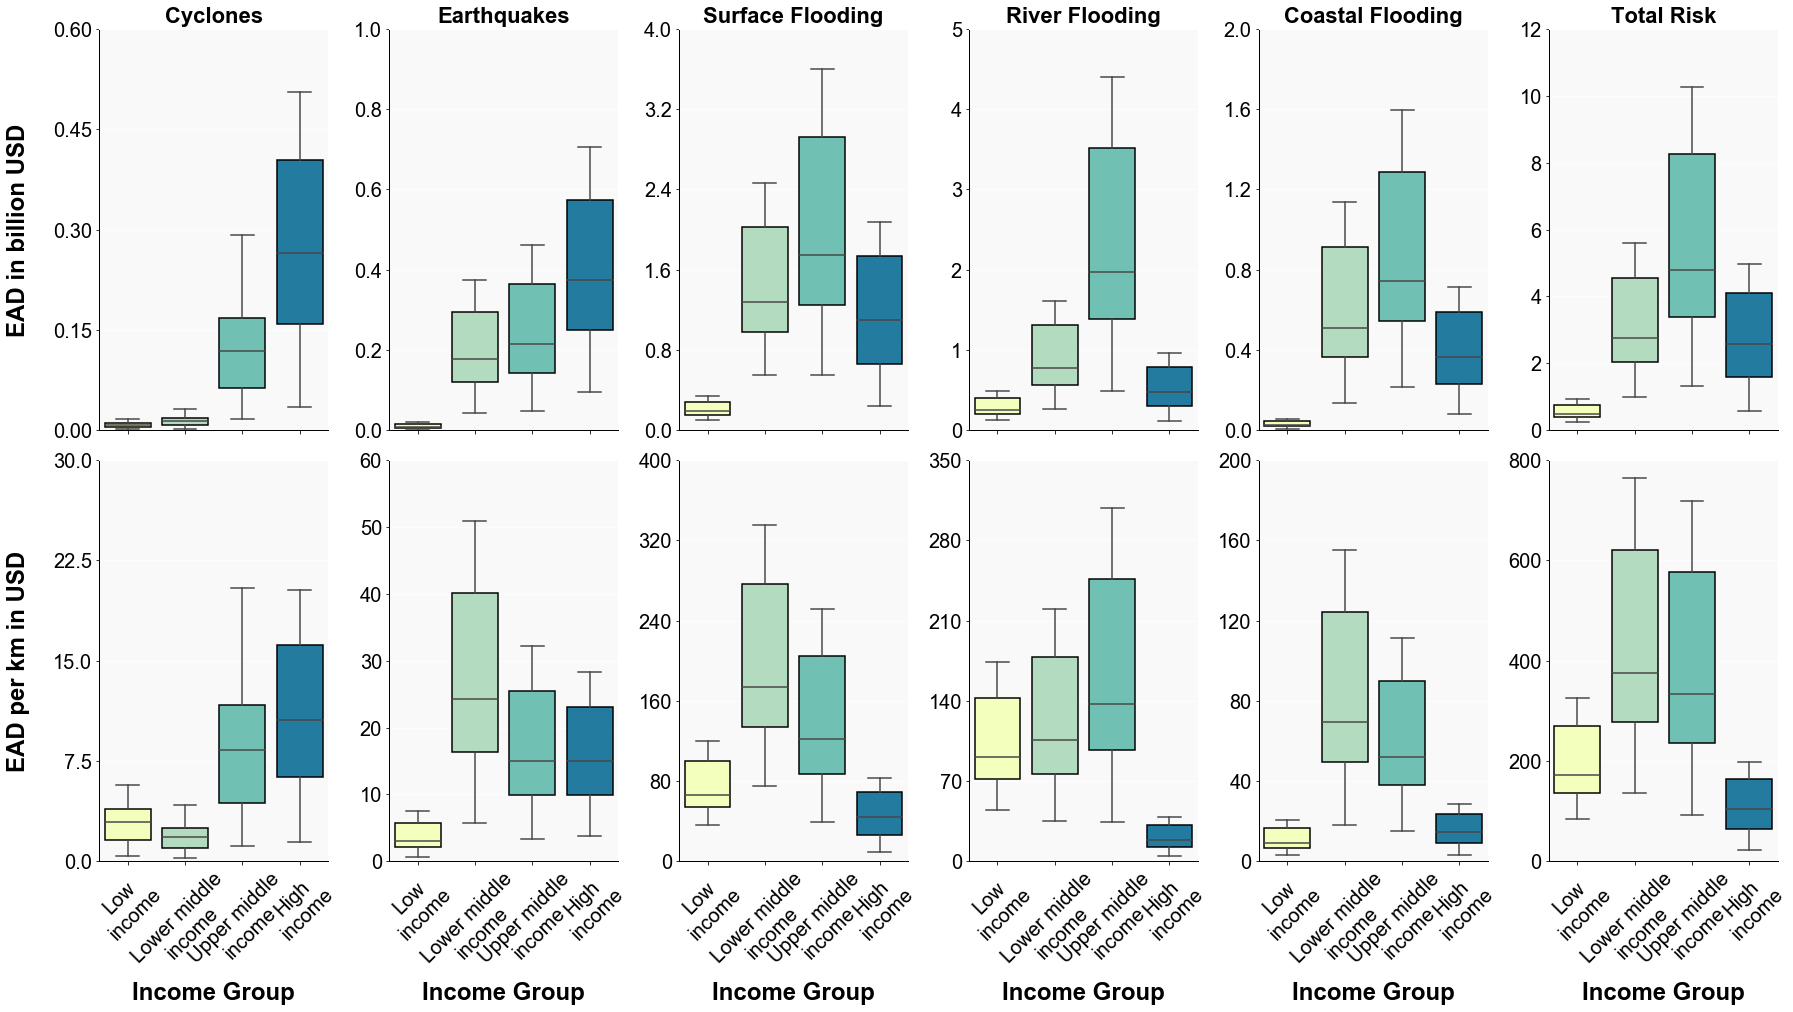

In [16]:
### absolute numbers
hazards = ['Cyc','EQ','PU','FU','CF','Tot','Cyc','EQ','PU','FU','CF','Tot']
hazards_full = ['Cyclones','Earthquakes','Surface Flooding','River Flooding','Coastal Flooding','Total Risk','Cyclones','Earthquakes','Surface Flooding','River Flooding','Coastal Flooding','Total']
fig, ax_losses = plt.subplots(2, 6,figsize=(25,14), sharex='col')  
gdp_income = dict(zip(list(GDP_group.index),list(GDP_group.GDP)))

color_scheme = ['#F3FFBD','#B2DBBF','#70C1B3','#247BA0'] #['#bae4bc','#7bccc4','#43a2ca','#0868ac']
income_dict = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
income_axis = ['Low\nincome', 'Lower middle\nincome', 'Upper middle\nincome', 'High\nincome']

#color_scheme = ['#F3FFBD','#B2DBBF','#70C1B3','#247BA0','#bae4bc','#7bccc4','#43a2ca']
#income_dict = ['SAS', 'SSA', 'ECA', 'YHI', 'LAC', 'EAP', 'MNA']
#income_axis = ['SAS', 'SSA', 'ECA', 'YHI', 'LAC', 'EAP', 'MNA']

color_lookup = dict(zip(income_dict,color_scheme))
axis_lookup = dict(zip(income_dict,income_axis))

wb_agg = []
wb_agg_sum = []
wb_rel = {}
for iter_,ax_loss in enumerate(ax_losses.flat):
    if iter_ == 6:
        wb_agg = []
    if (iter_ == 0) | (iter_ == 6):
        RPS = [1/50,1/100,1/250,1/500,1/1000]
        wb_risk_road = pd.DataFrame(Cyc_wb_stats_road.apply(lambda x: calc_risk_total(x,'Cyc',RPS,events_Cyc),axis=1).tolist(),
                               index=Cyc_wb_stats_road.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        wb_risk_rail = pd.DataFrame(Cyc_wb_stats_rail.apply(lambda x: calc_risk_total(x,'Cyc',RPS,events_Cyc),axis=1).tolist(),
                               index=Cyc_wb_stats_rail.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        
        wb_br_ro = pd.DataFrame(wb_road_bridge['Cyc_risk'].apply(pd.Series))
        wb_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ro = pd.concat([wb_br_ro.iloc[1:,:], pd.DataFrame(wb_br_ro.iloc[0,:]).T])
        wb_br_ro.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_br_ra = pd.DataFrame(wb_rail_bridge['Cyc_risk'].apply(pd.Series))
        wb_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ra = pd.concat([wb_br_ra.iloc[1:,:], pd.DataFrame(wb_br_ra.iloc[0,:]).T])
        wb_br_ra.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']


        wb_rel['Cyc'] = pd.concat(dict(zip(['Primary Roads','Secondary Roads','Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'],[wb_risk_road.loc['primary'],
                                                                                       wb_risk_road.loc['secondary'],wb_risk_road.loc['tertiary'],
                                                                                       wb_risk_rail,wb_br_ro,wb_br_ra])))
        wb_risk = wb_risk_road.groupby('GroupName').sum().add(wb_risk_rail).add(wb_br_ro).add(wb_br_ra)        
        wb_agg.append(wb_risk)
        
    elif (iter_ == 1) | (iter_ == 7):
        RPS = [1/250,1/475,1/975,1/1500,1/2475]
        wb_risk_road = pd.DataFrame(EQ_wb_stats_road.apply(lambda x: calc_risk_total(x,'EQ',RPS,events_EQ),axis=1).tolist(),
                               index=EQ_wb_stats_road.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        wb_risk_rail = pd.DataFrame(EQ_wb_stats_rail.apply(lambda x: calc_risk_total(x,'EQ',RPS,events_EQ),axis=1).tolist(),
                               index=EQ_wb_stats_rail.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])        
        wb_br_ro = pd.DataFrame(wb_road_bridge['EQ_risk'].apply(pd.Series))
        wb_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ro = pd.concat([wb_br_ro.iloc[1:,:], pd.DataFrame(wb_br_ro.iloc[0,:]).T])
        wb_br_ro.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_br_ra = pd.DataFrame(wb_rail_bridge['EQ_risk'].apply(pd.Series))
        wb_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ra = pd.concat([wb_br_ra.iloc[1:,:], pd.DataFrame(wb_br_ra.iloc[0,:]).T])
        wb_br_ra.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_rel['EQ'] = pd.concat(dict(zip(['Primary Roads','Secondary Roads','Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'],[wb_risk_road.loc['primary'],
                                                                                       wb_risk_road.loc['secondary'],wb_risk_road.loc['tertiary'],
                                                                                       wb_risk_rail,wb_br_ro,wb_br_ra])))
        wb_risk = wb_risk_road.groupby('GroupName').sum().add(wb_risk_rail).add(wb_br_ro).add(wb_br_ra)        
        wb_agg.append(wb_risk)
    elif (iter_ == 2) | (iter_ == 8):
        RPS = [1/5,1/10,1/20,1/50,1/75,1/100,1/200,1/250,1/500,1/1000]
        wb_risk_road = pd.DataFrame(PU_wb_stats_road.apply(lambda x: calc_risk_total(x,'PU',RPS,events_PU),axis=1).tolist(),
                               index=PU_wb_stats_road.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        wb_risk_rail = pd.DataFrame(PU_wb_stats_rail.apply(lambda x: calc_risk_total(x,'PU',RPS,events_PU),axis=1).tolist(),
                               index=PU_wb_stats_rail.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])        
        wb_br_ro = pd.DataFrame(wb_road_bridge['PU_risk'].apply(pd.Series))
        wb_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ro = pd.concat([wb_br_ro.iloc[1:,:], pd.DataFrame(wb_br_ro.iloc[0,:]).T])
        wb_br_ro.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_br_ra = pd.DataFrame(wb_rail_bridge['PU_risk'].apply(pd.Series))
        wb_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ra = pd.concat([wb_br_ra.iloc[1:,:], pd.DataFrame(wb_br_ra.iloc[0,:]).T])
        wb_br_ra.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_rel['PU'] = pd.concat(dict(zip(['Primary Roads','Secondary Roads','Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'],[wb_risk_road.loc['primary'],
                                                                                       wb_risk_road.loc['secondary'],wb_risk_road.loc['tertiary'],
                                                                                       wb_risk_rail,wb_br_ro,wb_br_ra])))
        wb_risk = wb_risk_road.groupby('GroupName').sum().add(wb_risk_rail).add(wb_br_ro).add(wb_br_ra)        
        wb_agg.append(wb_risk) 
        
    elif (iter_ == 3) | (iter_ == 9):
        RPS = [1/5,1/10,1/20,1/50,1/75,1/100,1/200,1/250,1/500,1/1000]
        wb_risk_road = pd.DataFrame(FU_wb_stats_road.apply(lambda x: calc_risk_total(x,'FU',RPS,events_FU),axis=1).tolist(),
                               index=FU_wb_stats_road.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        wb_risk_rail = pd.DataFrame(FU_wb_stats_rail.apply(lambda x: calc_risk_total(x,'FU',RPS,events_FU),axis=1).tolist(),
                               index=FU_wb_stats_rail.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])        
        wb_br_ro = pd.DataFrame(wb_road_bridge['FU_risk'].apply(pd.Series))
        wb_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ro = pd.concat([wb_br_ro.iloc[1:,:], pd.DataFrame(wb_br_ro.iloc[0,:]).T])
        wb_br_ro.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_br_ra = pd.DataFrame(wb_rail_bridge['FU_risk'].apply(pd.Series))
        wb_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ra = pd.concat([wb_br_ra.iloc[1:,:], pd.DataFrame(wb_br_ra.iloc[0,:]).T])
        wb_br_ra.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_rel['FU'] = pd.concat(dict(zip(['Primary Roads','Secondary Roads','Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'],[wb_risk_road.loc['primary'],
                                                                                       wb_risk_road.loc['secondary'],wb_risk_road.loc['tertiary'],
                                                                                       wb_risk_rail,wb_br_ro,wb_br_ra])))
        wb_risk = wb_risk_road.groupby('GroupName').sum().add(wb_risk_rail).add(wb_br_ro).add(wb_br_ra)        
        wb_agg.append(wb_risk) 

    elif (iter_ == 4) | (iter_ == 10):
        RPS = [1/10,1/20,1/50,1/100,1/200,1/500,1/1000]
        wb_risk_road = pd.DataFrame(CF_wb_stats_road.apply(lambda x: calc_risk_total(x,'CF',RPS,events_CF),axis=1).tolist(),
                               index=CF_wb_stats_road.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])
        wb_risk_rail = pd.DataFrame(CF_wb_stats_rail.apply(lambda x: calc_risk_total(x,'CF',RPS,events_CF),axis=1).tolist(),
                               index=CF_wb_stats_rail.index,
             columns=['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100'])        
        wb_br_ro = pd.DataFrame(wb_road_bridge['CF_risk'].apply(pd.Series))
        wb_br_ro.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ro = pd.concat([wb_br_ro.iloc[1:,:], pd.DataFrame(wb_br_ro.iloc[0,:]).T])
        wb_br_ro.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_br_ra = pd.DataFrame(wb_rail_bridge['CF_risk'].apply(pd.Series))
        wb_br_ra.columns = ['perc_0','perc_20','perc_40','perc_50','perc_60','perc_80','perc_100']
        wb_br_ra = pd.concat([wb_br_ra.iloc[1:,:], pd.DataFrame(wb_br_ra.iloc[0,:]).T])
        wb_br_ra.index =  ['Low income', 'Lower middle income', 'Upper middle income', 'High income']

        wb_rel['CF'] = pd.concat(dict(zip(['Primary Roads','Secondary Roads','Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'],[wb_risk_road.loc['primary'],
                                                                                       wb_risk_road.loc['secondary'],wb_risk_road.loc['tertiary'],
                                                                                       wb_risk_rail,wb_br_ro,wb_br_ra])))
        wb_risk = wb_risk_road.groupby('GroupName').sum().add(wb_risk_rail).add(wb_br_ro).add(wb_br_ra)        
        wb_agg.append(wb_risk) 

    elif (iter_ == 5) | (iter_ == 11):
        wb_risk = pd.concat(wb_agg).groupby(level=0,axis=0).sum()
        
    if iter_ < 6:
        wb_agg_sum.append(wb_risk)
        wb_risk = wb_risk.T
        wb_risk = pd.DataFrame(wb_risk.unstack(0),columns=['data'])
        wb_risk = wb_risk/1000000000
        wb_risk.index.names = ['wbincome','perc']
        wb_risk.reset_index(inplace=True)
        wb_risk.wbincome = wb_risk.wbincome.astype("category")
        wb_risk.wbincome.cat.set_categories(income_dict, inplace=True)
        wb_risk = wb_risk.sort_values(["wbincome"])
        sorted_income = list(wb_risk.wbincome.unique())
        wb_risk['wbincome'] = wb_risk.wbincome.apply(lambda x: axis_lookup[x])

        sns.boxplot(x="wbincome", y="data",
                                 data=wb_risk,showfliers=False,ax=ax_loss)   
    elif iter_ > 5:
        wb_risk = wb_risk.T
        if iter_ != 11:
            for col in wb_risk.columns:
                wb_risk[col] = wb_risk[col]/lookup_length[col]

        wb_risk = pd.DataFrame(wb_risk.unstack(0),columns=['data'])
        wb_risk.index.names = ['wbincome','perc']
        wb_risk.reset_index(inplace=True)
        wb_risk.wbincome = wb_risk.wbincome.astype("category")
        wb_risk.wbincome.cat.set_categories(income_dict, inplace=True)
        wb_risk = wb_risk.sort_values(["wbincome"])

        sorted_income = list(wb_risk.wbincome.unique())
        wb_risk['wbincome'] = wb_risk.wbincome.apply(lambda x: axis_lookup[x])
        sns.boxplot(x="wbincome", y="data",
                                 data=wb_risk,showfliers=False,ax=ax_loss)   

    if iter_ > 5:
        for tick in ax_loss.get_xticklabels():
            tick.set_rotation(45)
        ax_loss.set_xlabel('Income Group', fontsize=24,fontweight='bold',color='black')
        ax_loss.get_xaxis().set_label_coords(0.5,-0.3)
    else:
        ax_loss.set_title(hazards_full[iter_],fontweight='bold', fontsize=22)
        ax_loss.set_xlabel('')
        
    for y in range(4):
        ax_loss.findobj(matplotlib.patches.Patch)[y].set_facecolor(color_lookup[sorted_income[y]])
        ax_loss.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')

    ax_loss.set_facecolor('#FAF9F9')
    ax_loss.spines['left'].set_color('black')
    ax_loss.spines['bottom'].set_color('black')
    ax_loss.tick_params(axis = 'both',labelsize=20,labelcolor='black',color='black')

    yaxis_allticks = [np.arange(0,0.61,0.15),np.arange(0,1.1,0.2),np.arange(0,4.1,0.8),np.arange(0,5.1,1),np.arange(0,2.01,0.4),np.arange(0,12.1,2)
                      #,np.arange(0,0.001,.0001),np.arange(0,0.001,.0001),np.arange(0,0.01,.005),np.arange(0,0.01,.005),np.arange(0,0.1,.05),np.arange(0,0.1,.05)]
                      
                      ,np.arange(0,31,7.5),np.arange(0,61,10),np.arange(0,401,80),np.arange(0,351,70),np.arange(0,201,40),np.arange(0,801,200)]
    ax_loss.yaxis.set_ticks(yaxis_allticks[iter_])
    ax_loss.set_ylim([yaxis_allticks[iter_][0],yaxis_allticks[iter_][-1]])
    ax_loss.set_facecolor('#FAF9F9')
    if iter_ == 0:
        ax_loss.set_ylabel('EAD in billion USD', fontsize=24,fontweight='bold',color='black')
        ax_loss.get_yaxis().set_label_coords(-0.3,0.5)
    elif iter_ == 6:
        ax_loss.set_ylabel('EAD per km in USD', fontsize=24,fontweight='bold',color='black')
        ax_loss.get_yaxis().set_label_coords(-0.3,0.5)
    else:
        ax_loss.set_ylabel('')
        

fig.subplots_adjust(wspace=0.05, hspace=0.1,top=0.88)
fig.tight_layout(rect=[0, 0, 1, 1])    
fig.savefig(os.path.join(data_path,'Figures','Fig4_losses.png'),dpi=450)

## Figure 3

C:\Users\cenv0574\AppData\Local\Continuum\miniconda3\envs\py36\lib\site-packages\matplotlib\tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


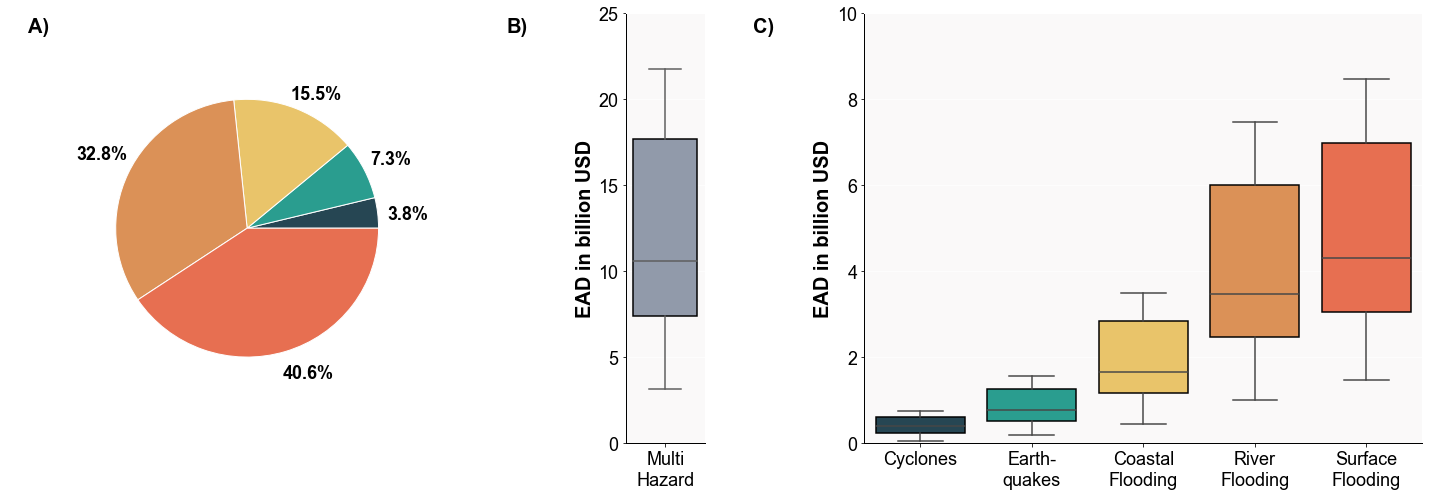

In [17]:
hzd_sum = pd.concat(dict(zip(['Cyc','EQ','PU','FU','CF'],wb_agg_sum))).groupby(level=0,axis=0).sum()/1e9
hzd_sum = hzd_sum.reindex(['Cyc','EQ','CF','FU','PU'])
hzd_sum.index = ['Cyclones','Earth-\nquakes','Coastal\nFlooding','River\nFlooding','Surface\nFlooding']
data = pd.DataFrame(hzd_sum.stack(),columns=['value']).reset_index()

fig  = plt.figure(figsize=(20,7)) #, sharey='row'
gs = gridspec.GridSpec(1, 12)

letters = ['A','B','C']

color_scheme_map = ['#264653','#2A9D8F','#E9C46A','#DB9157','#E76F51'] 

for iter_ in range(3):
    if iter_ == 0:
        df = data.loc[data.level_1 == 'perc_50']
        df = df.groupby(['level_0','level_1']).sum()
        df.columns=['val1']
        df = df.reindex(['Cyclones','Earth-\nquakes','Coastal\nFlooding','River\nFlooding','Surface\nFlooding'],level=0)
        df['cum_sum'] = df.val1.cumsum()
        df['cum_perc'] = df.cum_sum/df.val1.sum()
        df['theta'] = df.cum_perc*360
        df['perc'] = df.val1/df.val1.sum()*100
        df['perc'] = df['perc'].apply(lambda x : round(x,1))
        thetas = list(df['theta'])        
        ax = plt.subplot(gs[0,:4])
        
        wed1 = matplotlib.patches.Wedge((0.5, 0.5), 0.3,0, thetas[0],facecolor=color_scheme_map[0],linewidth=1,edgecolor='white')
        wed2 = matplotlib.patches.Wedge((0.5, 0.5), 0.3,thetas[0], thetas[1],facecolor=color_scheme_map[1],linewidth=1,edgecolor='white')
        wed3 = matplotlib.patches.Wedge((0.5, 0.5), 0.3,thetas[1], thetas[2],facecolor=color_scheme_map[2],linewidth=1,edgecolor='white')
        wed4 = matplotlib.patches.Wedge((0.5, 0.5), 0.3,thetas[2], thetas[3],facecolor=color_scheme_map[3],linewidth=1,edgecolor='white')
        wed5 = matplotlib.patches.Wedge((0.5, 0.5), 0.3,thetas[3], thetas[4],facecolor=color_scheme_map[4],linewidth=1,edgecolor='white')

        # set translation 
        ax.add_patch(wed1)
        ax.add_patch(wed2)
        ax.add_patch(wed3)
        ax.add_patch(wed4)
        ax.add_patch(wed5)
        
        ax.set_facecolor('white')
        ax.set_axis_off()
        ax.annotate("{}%".format(df['perc'].iloc[0]), xy=(0.82,0.52), fontsize=18,fontweight='bold')
        ax.annotate("{}%".format(df['perc'].iloc[1]), xy=(0.78,0.65), fontsize=18,fontweight='bold')
        ax.annotate("{}%".format(df['perc'].iloc[2]), xy=(0.6,0.8), fontsize=18,fontweight='bold')
        ax.annotate("{}%".format(df['perc'].iloc[3]), xy=(0.11,0.66), fontsize=18,fontweight='bold')
        ax.annotate("{}%".format(df['perc'].iloc[4]), xy=(0.58,0.15), fontsize=18,fontweight='bold')
        ax.text(0, 0.99, '{})'.format(letters[iter_]), transform=ax.transAxes,fontweight="bold",color='black', fontsize=20,
            verticalalignment='top', bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))   
    if iter_ == 1:
        data2 = pd.DataFrame(hzd_sum.sum(axis=0),columns=['value']).reset_index()
        data2['level_0'] = 'Multi\nHazard'
        ax = plt.subplot(gs[0,5:6])


        sns.boxplot(data=data2,x='level_0',y='value',showfliers=False,color='#8D99AE')
        ax.set_facecolor('#FAF9F9')
        ax.set_ylabel('EAD in billion USD', fontsize=20,fontweight='bold',color='black')

        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.tick_params(axis = 'both',labelsize=18,labelcolor='black',color='black')
       
        ax.set_xlabel('', fontsize=20,fontweight='bold',color='black')
        ax.yaxis.set_ticks(np.arange(0,25.5,5))
        ax.findobj(matplotlib.patches.Patch)[0].set_edgecolor('black')
        ax.text(-1.5, 0.99, '{})'.format(letters[iter_]), transform=ax.transAxes,fontweight="bold",color='black', fontsize=20,
            verticalalignment='top', bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))   

    if iter_ == 2:
        ax = plt.subplot(gs[0,7:])
        color_scheme_map = ['#264653','#2A9D8F','#E9C46A','#DB9157','#E76F51'] 

        sns.boxplot(data=data,x='level_0',y='value',showfliers=False)
        ax.set_facecolor('#FAF9F9')

        ax.set_ylabel('EAD in billion USD', fontsize=20,fontweight='bold',color='black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_xlabel('', fontsize=20,fontweight='bold',color='black')
        ax.tick_params(axis = 'both',labelsize=18,labelcolor='black',color='black')
        ax.set_ylim([0,10])
        
        for y in range(5):
            ax.findobj(matplotlib.patches.Patch)[y].set_facecolor(color_scheme_map[y])
            ax.findobj(matplotlib.patches.Patch)[y].set_edgecolor('black')

        ax.text(-0.2, 0.99, '{})'.format(letters[iter_]), transform=ax.transAxes,fontweight="bold",color='black', fontsize=20,
            verticalalignment='top', bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))

fig.tight_layout()
fig.savefig(os.path.join(data_path,'Figures','Fig3_total_losses.png'),dpi=450)

In [18]:
list(wb_risk.wbincome.unique())

['Low\nincome', 'Lower middle\nincome', 'Upper middle\nincome', 'High\nincome']

In [19]:
data2.value.mean()

14.619157648787835

In [20]:
(hzd_sum/hzd_sum.sum()).median(axis=1)*100

Cyclones              3.327627
Earth-\nquakes        7.179019
Coastal\nFlooding    15.670720
River\nFlooding      33.309488
Surface\nFlooding    40.620831
dtype: float64

In [21]:
data = pd.concat(wb_rel)['perc_50'].unstack([2,0])
data = data.reindex(['Primary Roads', 'Secondary Roads', 'Tertiary Roads','Bridge_Road','Rail','Bridge_Rail'])

In [22]:
pd.concat(wb_rel).to_csv(os.path.join(data_path,'output_data','wb_group_risk.csv'))

In [23]:
data[('Upper middle income','CF')]/data[('Upper middle income','CF')].sum()*100

Primary Roads      49.057984
Secondary Roads     8.983365
Tertiary Roads     22.566619
Bridge_Road        15.452962
Rail                1.384434
Bridge_Rail         2.554635
Name: (Upper middle income, CF), dtype: float64

## Figure S5

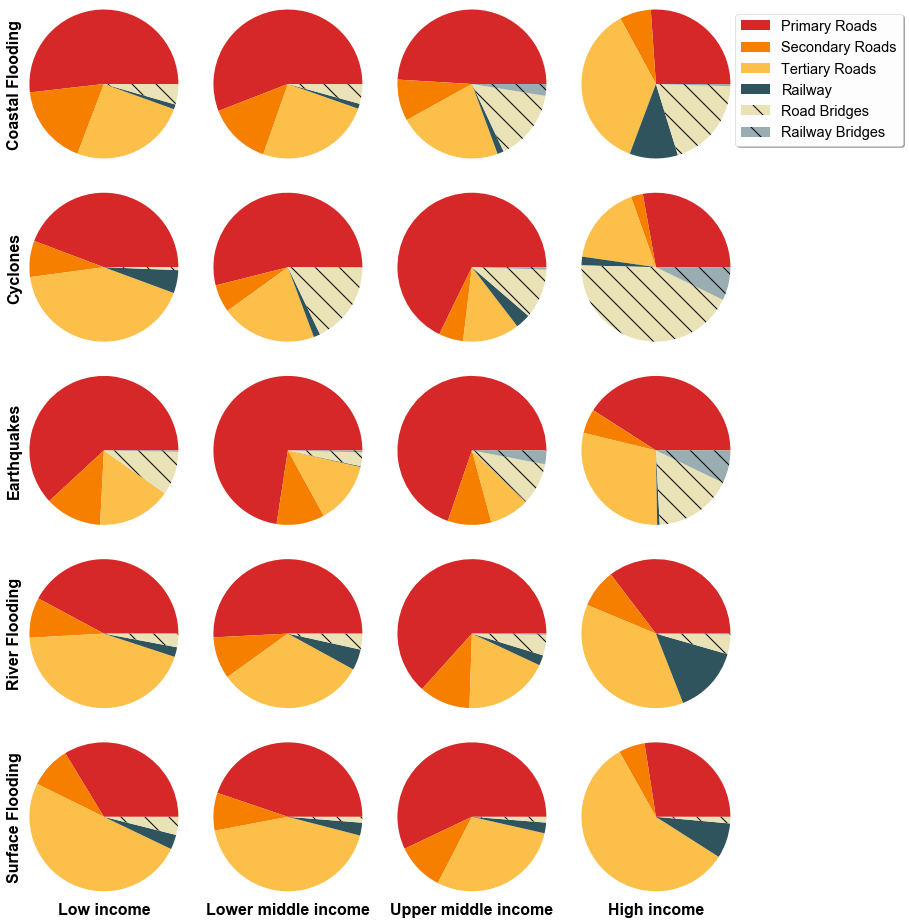

In [24]:
fig, ax = plt.subplots(5, 4,figsize=(13,13), sharex='col', sharey='col')  
colors = ['#D62828','#F77F00','#FCBF49','#2F545E','#EAE2B7','#99adb3']# ['#fdb863','#b2abd2','#e66101','#5e3c99']

data = pd.concat(wb_rel)['perc_50'].unstack([2,0])
data = data.reindex(['Primary Roads', 'Secondary Roads', 'Tertiary Roads','Rail','Bridge_Road','Bridge_Rail'])

data.plot(kind='pie',subplots=True,colors = colors, labels=None,
          ax=ax, radius=1.2,legend=False) # 'linewidth' : 0.5 , 'edgecolor' : 'black', 'alpha' : 0.8}

[axi.tick_params(axis='both', which='both', length=0) for iter_,axi in enumerate(ax.ravel())]
[axi.patches[4].set_hatch("\\") for iter_,axi in enumerate(ax.ravel())]
[axi.patches[5].set_hatch("\\") for iter_,axi in enumerate(ax.ravel())]

hazards_pie = ['Coastal Flooding','Cyclones','Earthquakes','River Flooding','Surface Flooding']

[axi.set_xlabel(xlabel=income_dict[iter_-16],fontweight='bold',fontsize=16,color='black') for iter_,axi in enumerate(ax.ravel()) if iter_ > 15]

ylocs_hz = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4]
ylocs = [0,4,8,12,16]
[axi.set_ylabel(ylabel=hazards_pie[ylocs_hz[iter_]],fontweight='bold',fontsize=16,color='black') for iter_,axi in enumerate(ax.ravel()) if iter_ in ylocs]

legend_elements = [Patch(facecolor=colors[0],label='Primary Roads'), #,edgecolor='black',linewidth=0.3
                   Patch(facecolor=colors[1],label='Secondary Roads'),
                   Patch(facecolor=colors[2],label='Tertiary Roads'),
                   Patch(facecolor=colors[3],label='Railway'),
                   Patch(facecolor=colors[4],label='Road Bridges'),                   
                   Patch(facecolor=colors[5],label='Railway Bridges')]        

[element.set_hatch("\\") for iter_,element in enumerate(legend_elements) if iter_ > 3]
    
[axi.legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(1.55, 1.), shadow=True, 
                           fancybox=True,facecolor='#fefdfd',prop={'size':14.5}) for iter_,axi in enumerate(ax.ravel()) if iter_ == 3]


fig.tight_layout()
fig.subplots_adjust(left=0.05,right=0.82) 
fig.savefig(os.path.join(data_path,'Figures','FigS5_distribution.png'),dpi=450)

## Low vs high probability impact

In [25]:
def get_mean(x,columns):
    for col in columns:
        x[col] = np.mean(x[col])
    return x

In [26]:
FU_risk = FU_wb_stats_road.apply(lambda x : get_mean(x,list(FU_wb_stats_road.columns)),axis=1).sum(axis=0)/1e9
PU_risk = PU_wb_stats_road.apply(lambda x : get_mean(x,list(PU_wb_stats_road.columns)),axis=1).sum(axis=0)/1e9
Cyc_risk = Cyc_wb_stats_road.apply(lambda x : get_mean(x,list(Cyc_wb_stats_road.columns)),axis=1).sum(axis=0)/1e9
EQ_risk = EQ_wb_stats_road.apply(lambda x : get_mean(x,list(EQ_wb_stats_road.columns)),axis=1).sum(axis=0)/1e9
CF_risk = CF_wb_stats_road.apply(lambda x : get_mean(x,list(CF_wb_stats_road.columns)),axis=1).sum(axis=0)/1e9

In [27]:
CF_risk.index = [10,20,100,50,1000,200,500]
PU_risk.index = [5,10,20,50,75,100,200,250,500,1000]
FU_risk.index = [5,10,20,50,75,100,200,250,500,1000]
Cyc_risk.index = [50,100,250,500,1000]
EQ_risk.index = [250,475,975,1500,2475]

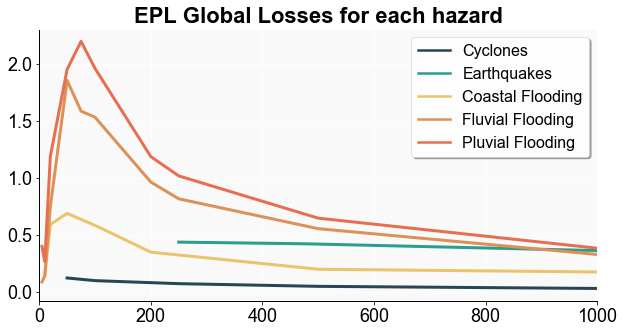

In [28]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
(Cyc_risk*(1/Cyc_risk.index)).sort_index().plot(ax=ax,color=color_scheme_map[0],linewidth=3)
(EQ_risk*(1/EQ_risk.index)).sort_index().plot(ax=ax,color=color_scheme_map[1],linewidth=3)
(CF_risk*(1/CF_risk.index)).sort_index().plot(ax=ax,color=color_scheme_map[2],linewidth=3)
(FU_risk*(1/FU_risk.index)).sort_index().plot(ax=ax,color=color_scheme_map[3],linewidth=3)
(PU_risk*(1/PU_risk.index)).sort_index().plot(ax=ax,color=color_scheme_map[4],linewidth=3)
ax.set_facecolor('#FAF9F9')

ax.set_ylabel('', fontsize=20,fontweight='bold',color='black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_xlabel('', fontsize=20,fontweight='bold',color='black')
ax.tick_params(axis = 'both',labelsize=18,labelcolor='black',color='black')

custom_lines = [Line2D([0], [0], color=color_scheme_map[0], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[1], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[2], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[3], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[4], lw=2.5)]

legend = ax.legend(custom_lines, ['Cyclones','Earthquakes','Coastal Flooding','Fluvial Flooding','Pluvial Flooding'],shadow=True, 
                       fancybox=True,facecolor='#fefdfd',prop={'size':16})

ax.set_title('EPL Global Losses for each hazard', fontsize=22,fontweight='bold',color='black')
ax.set_xlim(left=0,right=1000)

fig.savefig(os.path.join(data_path,'Figures','EPL_hazards.png'),dpi=450)

(0, 1000)

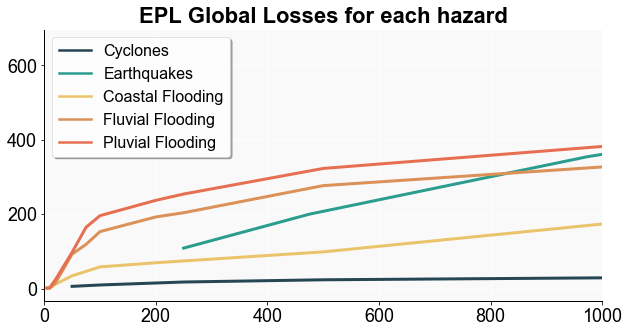

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
(Cyc_risk).sort_index().plot(ax=ax,color=color_scheme_map[0],linewidth=3)
(EQ_risk).sort_index().plot(ax=ax,color=color_scheme_map[1],linewidth=3)
(CF_risk).sort_index().plot(ax=ax,color=color_scheme_map[2],linewidth=3)
(FU_risk).sort_index().plot(ax=ax,color=color_scheme_map[3],linewidth=3)
(PU_risk).sort_index().plot(ax=ax,color=color_scheme_map[4],linewidth=3)
ax.set_facecolor('#FAF9F9')

ax.set_ylabel('', fontsize=20,fontweight='bold',color='black')
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.set_xlabel('', fontsize=20,fontweight='bold',color='black')
ax.tick_params(axis = 'both',labelsize=18,labelcolor='black',color='black')

custom_lines = [Line2D([0], [0], color=color_scheme_map[0], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[1], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[2], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[3], lw=2.5),
                Line2D([0], [0], color=color_scheme_map[4], lw=2.5)]

legend = ax.legend(custom_lines, ['Cyclones','Earthquakes','Coastal Flooding','Fluvial Flooding','Pluvial Flooding'],shadow=True, 
                       fancybox=True,facecolor='#fefdfd',prop={'size':16})

ax.set_title('EPL Global Losses for each hazard', fontsize=22,fontweight='bold',color='black')
ax.set_xlim(left=0,right=1000)

#fig.savefig(os.path.join(data_path,'Figures','EPL_hazards.png'),dpi=450)